## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

### Note to the Evaluator(s)

The code being submitted is set up to run 5 million EPISODEs from scratch (without loading any prior policy or states_tracking.pkl files), with a decaying epsilon rate. Following are some statistics collected
- 34% of the episodes won by Agent
- 25% of the episodes lost by Agent
- 41% of the episodes were tied
- 31% of the steps used Exploitation while the rest of the 69% were exploratory moves by the agent
- A total of 3.7 million states were generated, of which, 1.7 mn had no values generated.


I then re-ran the code with the following changes
1. 10,000 episodes
1. Use previously generated *Policy* and *States_tracker* files
2. Full Exploitation mode for Agent moves i.e., use only moves as per Policy file (no use of Epsilon)

This was done to check how much RL has happened.
With this run, the agent now won 85% of the episodes with 6% loss and 9% tied.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp "/content/drive/My Drive/Colab Notebooks/Assign-TicTacToe/TCGame_Env.py" .

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
import datetime

from matplotlib import pyplot as plt

#### Define hyperparameters  

In [3]:
#Defining parameters for "test mode" run
mode_dict = {0:'FULL EXPLOIT mode', 1:'FULL EXPLORE mode', 2:'EPSILON mode'}
MODE = 2
FRESH_START = True # If False, load previously saved pkl files for Policy & State_tracking
    

#Defining parameters for the experiment
EPISODES =   5000000
STEPS = 9                 #for 9 squares
LR = 0.01                 #learning rate
GAMMA = 0.91

#every these many episodes, the Q-values & Q_dict will be stored/appended (convergence graphs)
#set up threshold to be 10% of the value of EPISODES.
if (EPISODES < 10):
    threshold=1
    policy_threshold=1 
else:
    threshold = round(EPISODES*0.1,0)
    policy_threshold = round(EPISODES*0.1,0)

ex_dict={False:'Exploiting', True:'Exploring'}

#### Define All Functions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    added=False
    valid_act = valid_actions(state)
    if state_key not in Q_dict.keys():
        for action in valid_act:
            added=True
            Q_dict[state_key][action]=0


In [5]:
def add_to_state_tracker(state):
    state_key = Q_state(state)
    valid_act = valid_actions(state)
    if state_key not in States_tracker.keys():
        for action in valid_act:
            States_tracker[state_key][action] = []


In [6]:
def epsilon_greedy(state, episode):  
    #grab epsilon from the EPSILON list created based on decay rate.
    epsilon = EPSILON[episode]
    z = np.random.random()
    
    if (MODE==0):
    # FORCE FULL EXPLOIT mode by making z > epsilon
        epsilon = z-1
    elif (MODE==1):
    # FORCE FULL EXPLORE mode by making z < epsilon
        epsilon = z+1

    state_str = Q_state(state)
    if z > epsilon:
        action = max(Q_dict[state_str],key=Q_dict[state_str].get)   #Exploitation: this gets the action corresponding to max q-value of current state
        explore_flg=False #Exploiting
    else:
        #Exploration: randomly choosing from allowable odd numbers (RL can only play odd numbers)
        agt_actions, env_actions = env.action_space(state)
        agt_actions_list = [item for item in agt_actions]
        action = agt_actions_list[np.random.choice(np.arange(len(agt_actions_list)))]
        explore_flg=True #Exploring
    
    return action, explore_flg 

In [7]:
# Initialise states to be tracked
def initialise_outcomes():
    Outcomes_tracker = []
  


In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    States_tracker = []
  

In [9]:
# Initialise Q_dict
def initialise_Q_dict():
    return 

In [10]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [11]:
def random_action():
    pos = np.random.choice(np.arange(9))
    val = np.random.choice(np.arange(1,9,2)) #randomly choosing an action from one of the odd numbers since that's what the RL agent is allowed
    return pos,val

In [12]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
def save_outcomes(episode,outcome):
    for state in Outcomes_tracker.keys():
        for action in Outcomes_tracker[state].keys():
            value = (episode,outcome)
            Outcomes_tracker[state][action].append(value)


In [14]:
def save_tracking_state(state,action,q_value,episode,rwd):
    state_key=Q_state(state)
    if (state_key in Q_dict) and (action in Q_dict[state_key]):
#        tracking_value=(q_value,rwd)
#        tracking_value=(episode,q_value,rwd)
        tracking_value=q_value
        States_tracker[state_key][action].append(tracking_value)


In [16]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

#### Instantiate Environment

In [17]:
env = TicTacToe()  
print(env.state)


[nan, nan, nan, nan, nan, nan, nan, nan, nan]


#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [33]:
# Setup EPSILON Values spread across number of EPISODES
# This will be used by the greedy_epsilon function each time it is invoked for a step.

#def epsilon_greedy(state, time):
max_epsilon = 1.0
min_epsilon = 0.1
decay_rate=(max_epsilon-min_epsilon)/(EPISODES)
#decay_rate = 0.001
print(decay_rate)
time = np.arange(0,EPISODES)
EPSILON = []
for i in reversed(range(EPISODES)):
    EPSILON.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))


9e-06


In [19]:
print('max(EPSILON)',max(EPSILON))
print('min(EPSILON)',min(EPSILON))
print('EPSILON[0]', EPSILON[0])
print('EPSILON[-1]', EPSILON[-1])


max(EPSILON) 1.0
min(EPSILON) 0.46591598699560266
EPSILON[0] 0.46591598699560266
EPSILON[-1] 1.0


#### Tracking the state-action pairs for checking convergence - write your code here

In [20]:
if (FRESH_START):
    # Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_tracker' (for convergence)
    Q_dict = collections.defaultdict(dict)
    States_tracker = collections.defaultdict(dict)
    Rewards_tracker = collections.defaultdict(dict)
    Outcomes_tracker = collections.defaultdict(dict)

    initialise_tracking_states()
    initialise_outcomes()
else:    
    with open('Policy.pkl', 'rb') as handle:
        Q_dict = pickle.load(handle)
    
    with open('States_tracked.pkl', 'rb') as handle:
        States_tracker = pickle.load(handle)    
    
    print(len(Q_dict))
    print(len(States_tracker))
    

3769358
3769358


### Q-update loop ---write your code here

In [21]:
start_time = datetime.datetime.now()

#House-keeping/tracking variables
tot_exploits=0
tot_explores=0
agt_wins=0
agt_loss=0
ties=0
tot_agt_wins=0
tot_agt_loss = 0
tot_ties = 0
Outcomes_tracker = []

print(EPISODES, "Episodes Started ... @", start_time)
print(mode_dict[MODE], ';','Fresh Start:', FRESH_START, ';','Threshold:', threshold, ';','Policy Threshold:', policy_threshold)

ep_st_time=datetime.datetime.now()
for episode in range(EPISODES):
    # Initialize Episode level tracking variables/counters
    curr_state = env.state  
    total_reward = 0
    exploits=0 # to count the number of times Exploitation was taken
    explores=0 # to coun the number of times Exploration was taken
    terminal_state=False

    # Add current, initial state to Q_dict & State_tracker
    add_to_dict(curr_state)
    add_to_state_tracker(curr_state) 

    # Start of Episode loop
    step=1
    while (step <= STEPS) and (not terminal_state):    
    # Loop for STEPS (i.e 9) steps or Terminal state reached (Win/Lose/Tie), whichever is earlier. 

        # AGENT's MOVE
        # choose agent action
        if (step == 1):
        # for the first move/step, pick random (exploratory) move from one of the odd numbers since that's what the RL agent is allowed
            curr_action = random_action() 
            explore_flg = True
        else:
        #chose agent action now based on epsilon_greedy function 
            curr_action, explore_flg = epsilon_greedy(curr_state, episode)
            
            #check whether epsilon_greedy chose explotiation or exploration and increment counters accordingly.
            if (explore_flg):
                explores+=1
                tot_explores+=1
            else:
                exploits+=1
                tot_exploits+=1
                
        
        # ENVIRONMENT's MOVE
        #invoke environment step to get env response
        next_state, reward, terminal_state = env.step(curr_state, curr_action)
        
        # add state (and valid actions for the state) to Q_dict & States_tracker
        add_to_dict(next_state)  
        add_to_state_tracker(next_state) 
        
        total_reward += reward

        Q_dict_curr = Q_dict[Q_state(curr_state)][curr_action]
        
        # Q Update
        if terminal_state:
            Q_dict_upd = Q_dict_curr + LR * (reward - Q_dict_curr)
        else:
            # UPDATE RULE        
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict_max_next = Q_dict[Q_state(next_state)][max_next]
            Q_dict_upd = Q_dict_curr + LR * (reward + (GAMMA*Q_dict_max_next) - Q_dict_curr)
            
        Q_dict[Q_state(curr_state)][curr_action] = Q_dict_upd
        save_tracking_state(curr_state,curr_action,Q_dict_upd,episode,reward)

        curr_state = next_state  
        step +=1
    
    # Calculate some stats at the end of the episode
    if (reward==-10):
        episode_result = 'Agent Loss'
        agt_loss+=1
        tot_agt_loss+=1
    elif (reward==+10):
        episode_result = 'Agent Win'
        agt_wins+=1
        tot_agt_wins+=1
    elif (reward==0):
        episode_result = 'Tie'
        ties+=1
        tot_ties+=1

    # Save State at the threshold frequency of episodes
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        ep_end_time=datetime.datetime.now()
        print("Episodes done:", episode+1, '@', ep_end_time, '(',ep_end_time-ep_st_time,').')
        ep_st_time=datetime.datetime.now()

        #TRACKING STATE
#        print('# of Q_dict entries:', len(Q_dict))
#        save_tracking_states(episode,total_reward)
        save_obj(States_tracker,'States_tracked') 
        initialise_tracking_states()
        
        #TRACKING OUTCOME
 #       save_outcomes(episode,episode_result)    
 #       initialise_outcomes()
        
        agt_win_perc=round((agt_wins/threshold)*100,0)
        agt_loss_perc=round((agt_loss/threshold)*100,0)
        tie_perc=round((ties/threshold)*100,0)
        print('  Agent Win/Loss/Tie:', agt_wins,'(',agt_win_perc,'%)' \
                                 '/', agt_loss,'(',agt_loss_perc,'%)' \
                                 '/', ties,'(',tie_perc,'%)' )
        agt_wins = 0
        agt_loss = 0
        ties = 0

   
    # Save Policy at the threshold frequency.
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  
        save_obj(Q_dict,'Policy')    
        initialise_Q_dict()

#
#
# Stats at the end of all Episodes
#
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(EPISODES, "Episodes Ended ... @", end_time)
print('Elapsed time:',elapsed_time)

print() 

print('Total # of exploits:', tot_exploits, end=' ')
exploit_perc = round((tot_exploits / (tot_exploits+tot_explores))*100,0)
print('(',exploit_perc,'%)')

print('Total # of explores:', tot_explores, end=' ')
explore_perc = round((tot_explores / (tot_exploits+tot_explores))*100,0)
print('(',explore_perc,'%)')

print('Result Stats:')
agt_win_perc=round((tot_agt_wins/EPISODES)*100,0)
agt_loss_perc=round((tot_agt_loss/EPISODES)*100,0)
tie_perc=round((tot_ties/EPISODES)*100)
print('  Agent Wins:', tot_agt_wins, '(',agt_win_perc,'%)')
print('  Env Wins:', tot_agt_loss,'(',agt_loss_perc,'%)')
print('  Ties:', tot_ties,'(',tie_perc,'%)')



100000 Episodes Started ... @ 2020-01-27 15:47:39.207494
FULL EXPLOIT mode ; Fresh Start: False ; Threshold: 10000.0 ; Policy Threshold: 10000.0
Episodes done: 10000 @ 2020-01-27 15:47:57.295376 ( 0:00:18.085351 ).
  Agent Win/Loss/Tie: 8423 ( 84.0 %)/ 574 ( 6.0 %)/ 1003 ( 10.0 %)
Episodes done: 20000 @ 2020-01-27 15:49:19.509656 ( 0:01:22.213776 ).
  Agent Win/Loss/Tie: 8386 ( 84.0 %)/ 583 ( 6.0 %)/ 1031 ( 10.0 %)
Episodes done: 30000 @ 2020-01-27 15:50:44.409674 ( 0:01:24.898691 ).
  Agent Win/Loss/Tie: 8342 ( 83.0 %)/ 616 ( 6.0 %)/ 1042 ( 10.0 %)
Episodes done: 40000 @ 2020-01-27 15:52:18.903487 ( 0:01:34.490153 ).
  Agent Win/Loss/Tie: 8405 ( 84.0 %)/ 586 ( 6.0 %)/ 1009 ( 10.0 %)
Episodes done: 50000 @ 2020-01-27 15:53:44.223550 ( 0:01:25.318737 ).
  Agent Win/Loss/Tie: 8443 ( 84.0 %)/ 608 ( 6.0 %)/ 949 ( 9.0 %)
Episodes done: 60000 @ 2020-01-27 15:55:08.202908 ( 0:01:23.973887 ).
  Agent Win/Loss/Tie: 8391 ( 84.0 %)/ 634 ( 6.0 %)/ 975 ( 10.0 %)
Episodes done: 70000 @ 2020-01-27 15

#### Check the States-tracker

In [22]:
#
# Examine the States_tracker built.
#

len(States_tracker)
s_no_value=0
for s in Q_dict:
#    print('State:',s)
    val_count=0
    for action in Q_dict[s]:
        val = Q_dict[s][action]
        if (val !=0):
            val_count+=1
#            print(action,val)
#        print('State:', s,'; # of values:', val_count)
    if (val_count==0):  
#        print(s)
        s_no_value+=1
print('Of the total number of',len(Q_dict),'states', s_no_value, 'have no q-value.')
no_val_perc = (s_no_value/len(Q_dict))*100
print('(',round(no_val_perc,0),'%)')

Of the total number of 3775419 states 1750218 have no q-value.
( 46.0 %)


In [23]:
# Get a few state-action pairs and their visit count (i.e. # of values accumulated)
#
i = 0
for s in States_tracker:
    visits_count = 0
    visits_count_prev = 0
    j=0
    for action in States_tracker[s]:
        values = States_tracker[s][action]
        visits_count = len(values)
#        if (i%10000==0 and j%10==0):
        if (i%100000==0):
            print(s, action, visits_count)
#            print(values)
#            print('# of visits:', visits_count)
        visits_count_prev = visits_count
        j+=1
    i+=1
        

x-x-x-x-x-x-x-x-x (0, 1) 142503
x-x-x-x-x-x-x-x-x (0, 3) 142093
x-x-x-x-x-x-x-x-x (0, 5) 142431
x-x-x-x-x-x-x-x-x (0, 7) 142400
x-x-x-x-x-x-x-x-x (0, 9) 0
x-x-x-x-x-x-x-x-x (1, 1) 141866
x-x-x-x-x-x-x-x-x (1, 3) 142005
x-x-x-x-x-x-x-x-x (1, 5) 142213
x-x-x-x-x-x-x-x-x (1, 7) 142136
x-x-x-x-x-x-x-x-x (1, 9) 0
x-x-x-x-x-x-x-x-x (2, 1) 141581
x-x-x-x-x-x-x-x-x (2, 3) 142538
x-x-x-x-x-x-x-x-x (2, 5) 142594
x-x-x-x-x-x-x-x-x (2, 7) 142413
x-x-x-x-x-x-x-x-x (2, 9) 0
x-x-x-x-x-x-x-x-x (3, 1) 142262
x-x-x-x-x-x-x-x-x (3, 3) 142373
x-x-x-x-x-x-x-x-x (3, 5) 142236
x-x-x-x-x-x-x-x-x (3, 7) 141941
x-x-x-x-x-x-x-x-x (3, 9) 0
x-x-x-x-x-x-x-x-x (4, 1) 142645
x-x-x-x-x-x-x-x-x (4, 3) 142931
x-x-x-x-x-x-x-x-x (4, 5) 142088
x-x-x-x-x-x-x-x-x (4, 7) 141584
x-x-x-x-x-x-x-x-x (4, 9) 0
x-x-x-x-x-x-x-x-x (5, 1) 142658
x-x-x-x-x-x-x-x-x (5, 3) 142365
x-x-x-x-x-x-x-x-x (5, 5) 142544
x-x-x-x-x-x-x-x-x (5, 7) 142757
x-x-x-x-x-x-x-x-x (5, 9) 0
x-x-x-x-x-x-x-x-x (6, 1) 142230
x-x-x-x-x-x-x-x-x (6, 3) 142458
x-x-x-

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked
test_states = collections.defaultdict(dict)

test_states=(('x-x-x-x-x-x-x-x-x',(8,1)),\
             ('x-x-x-x-x-x-x-x-x',(4,5)),\
             ('x-x-x-x-x-x-x-x-x',(6,7)),\
             ('x-x-x-x-x-x-x-x-x',(7,1)))
'''
test_state={'x-x-3-x-8-x-x-x-x':(2, 3),\
'x-x-2-x-x-x-1-x-x':(6, 1),\
'7-x-x-x-x-6-x-x-x':(0, 7),\
'x-x-8-x-x-x-x-x-5':(8, 5)
           }
'''
Q_Values_Sample_Tracker = []
for state_action in test_states:
    print(state_action)
    

('x-x-x-x-x-x-x-x-x', (8, 1))
('x-x-x-x-x-x-x-x-x', (4, 5))
('x-x-x-x-x-x-x-x-x', (6, 7))
('x-x-x-x-x-x-x-x-x', (7, 1))


In [25]:
for state_action in test_states:
    state=state_action[0]
    action=state_action[1]
    qv_rwd = States_tracker[state][action]
    qv_list=[]
    for qv in qv_rwd:
        qv_list.append(qv)
    print(state,action,qv_list)
    Q_Values_Sample_Tracker.append([state,action,qv_list])

save_obj(Q_Values_Sample_Tracker, 'Sample-Tracker' )

x-x-x-x-x-x-x-x-x (8, 1) [-0.01, -0.0199, -0.029701, -0.03940399, -0.0490099501, -0.058519850599, -0.06793465209301, -0.07725530557207991, -0.0864827525163591, -0.09561792499119551, -0.10466174574128355, -0.11361512828387071, -0.12247897700103201, -0.1312541872310217, -0.13994164535871148, -0.14854222890512436, -0.15705680661607313, -0.1654862385499124, -0.17383137616441327, -0.18209306240276912, -0.19027213177874144, -0.19836941046095402, -0.20638571635634448, -0.21432185919278104, -0.22217864060085324, -0.2299568541948447, -0.23765728565289626, -0.2452807127963673, -0.25282790566840363, -0.26029962661171957, -0.26769663034560237, -0.27501966404214634, -0.28226946740172487, -0.28944677272770764, -0.29655230500043056, -0.30358678195042627, -0.310550914130922, -0.31744540498961277, -0.32427095093971664, -0.33102824143031945, -0.33771795901601626, -0.3443407794258561, -0.35089737163159757, -0.3573883979152816, -0.3638145139361288, -0.3701763687967675, -0.3764746051087998, -0.382709859057

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
len(Q_Values_Sample_Tracker[1][2])

142088

In [30]:
slice1 = 60000

slice2 = len(Q_Values_Sample_Tracker[0][2])
#slice2 = 16000

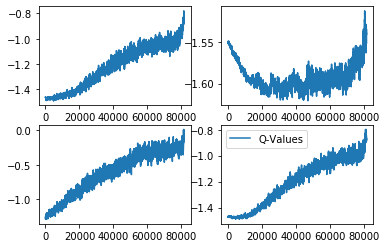

In [31]:
import matplotlib.pyplot as plt

plt.title("Convergence Plot - Q-Learning")

plt.subplot(221)
plt.plot(Q_Values_Sample_Tracker[0][2][slice1:slice2], label="Q-Values")

plt.subplot(222)
plt.plot(Q_Values_Sample_Tracker[1][2][slice1:slice2], label="Q-Values")

plt.subplot(223)
plt.plot(Q_Values_Sample_Tracker[2][2][slice1:slice2], label="Q-Values")

plt.subplot(224)
plt.plot(Q_Values_Sample_Tracker[3][2][slice1:slice2], label="Q-Values")

plt.legend()
#plt.tight_layout()



### Epsilon - decay check